<a href="https://colab.research.google.com/github/KADA-SEDODE/age-gender-prediction/blob/main/DL_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R√©alis√© par Cristian BEREGOI et Marvin KADA-SEDODE

# D√©tection de l'√¢ge et du sexe : Pr√©dire l'√¢ge et le sexe √† partir d'images de visages.  UTKFace Dataset

# le dataset UTKFace, qui est un jeu de donn√©es d‚Äôimages de visages annot√©s avec l'√¢ge, le sexe et l'ethnicit√©.

# Nombre total d'images charg√©es : 33488





In [ ]:
!pip install opencv-python

In [ ]:
#  Standard libraries
import os
import random
import cv2 # Import the cv2 module

#  Data manipulation & processing
import numpy as np
import pandas as pd
from PIL import Image

#  Visualisation
import matplotlib.pyplot as plt

import seaborn as sns

#  Progress bar
from tqdm import tqdm

#  PyTorch & TorchVision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import models, transforms

#  Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.models import inception_v3, Inception_V3_Weights


In [ ]:
#Cela me permet de me connceter au compte google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PARTIE 1

# CHARGEMENT DES DONNEES

In [ ]:
import zipfile

# D√©finir les chemins
zip_path = "/content/drive/MyDrive/archive (1).zip"
extract_path = "/content/UTKFace"  # Chemin d'extraction

# D√©compresser le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction termin√©e !")


Extraction termin√©e !


In [ ]:
# Lister les 3 premiers fichiers extraits
files = os.listdir(extract_path)
print(f"Nombre total de repertoires: {len(files)}") #dans notre extract_path on aura un dossier avec des sous dossier √† l'int√©rieure
print("Exemple de fichiers :", files[:3])
print()

Nombre total de repertoires: 3
Exemple de fichiers : ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']



In [ ]:
# Chemin o√π le dataset a √©t√© extrait
extract_path = "/content/UTKFace"

# V√©rifier les dossiers √† l'int√©rieur
folders = os.listdir(extract_path)# ca nous liste les dossiers √† l'interieure de extract_path
print("Dossiers trouv√©s :", folders)

# V√©rifier le contenu des sous-dossiers
for folder in folders:
    folder_path = os.path.join(extract_path, folder)
    if os.path.isdir(folder_path):# nous dis si c'est un dossier
        print(f"\n‚û° Contenu du dossier {folder}:")
        print(os.listdir(folder_path)[:10])  # Afficher les 10 premiers fichiers


Dossiers trouv√©s : ['crop_part1', 'UTKFace', 'utkface_aligned_cropped']

‚û° Contenu du dossier crop_part1:
['76_1_0_20170110182047993.jpg.chip.jpg', '26_1_2_20170109002657161.jpg.chip.jpg', '75_0_2_20170110131323894.jpg.chip.jpg', '13_0_0_20170110224625011.jpg.chip.jpg', '39_0_4_20170104200746817.jpg.chip.jpg', '2_0_4_20161221202356481.jpg.chip.jpg', '52_0_4_20170104184746311.jpg.chip.jpg', '14_1_2_20170104012048369.jpg.chip.jpg', '85_1_0_20170110183746742.jpg.chip.jpg', '22_1_2_20170104020216916.jpg.chip.jpg']

‚û° Contenu du dossier UTKFace:
['61_0_0_20170117174613406.jpg.chip.jpg', '32_1_1_20170113000615118.jpg.chip.jpg', '76_1_0_20170110182047993.jpg.chip.jpg', '26_1_2_20170109002657161.jpg.chip.jpg', '26_1_3_20170119193141890.jpg.chip.jpg', '27_1_2_20170116163003893.jpg.chip.jpg', '75_0_2_20170110131323894.jpg.chip.jpg', '32_1_0_20170117134803913.jpg.chip.jpg', '13_0_0_20170110224625011.jpg.chip.jpg', '49_1_1_20170113012017156.jpg.chip.jpg']

‚û° Contenu du dossier utkface_align

In [ ]:
image_folders = ["/content/UTKFace/crop_part1", "/content/UTKFace/UTKFace"] #on a les dossier des images

In [ ]:
# Fonction pour extraire √¢ge et sexe depuis le nom de fichier
def extract_labels(filename):
    """Extrait l'√¢ge et le sexe √† partir du nom du fichier."""
    try:
        age, gender, _ = filename.split("_")[:3]
        return int(age), int(gender)
    except:
        return None, None

# Charger les images et labels
data = []
for folder in image_folders:
    for filename in tqdm(os.listdir(folder)): # Parcourt chaque fichier dans le dossier
        age, gender = extract_labels(filename) #  Extrait l'√¢ge et le sexe du fichier.
        if age is not None:  #  V√©rifie que l‚Äôextraction a r√©ussi.
            img_path = os.path.join(folder, filename) # Construit le chemin complet de l‚Äôimage.
            data.append((img_path, age, gender)) #  Ajoute l‚Äôimage et ses labels √† la liste.

# Convertir en numpy array
data = np.array(data, dtype=object)
print(f"Nombre total d'images charg√©es : {len(data)}")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 23708/23708 [00:00<00:00, 297633.80it/s]

Nombre total d'images charg√©es : 33488


#  Visualiser la distribution des √¢ges et sexes

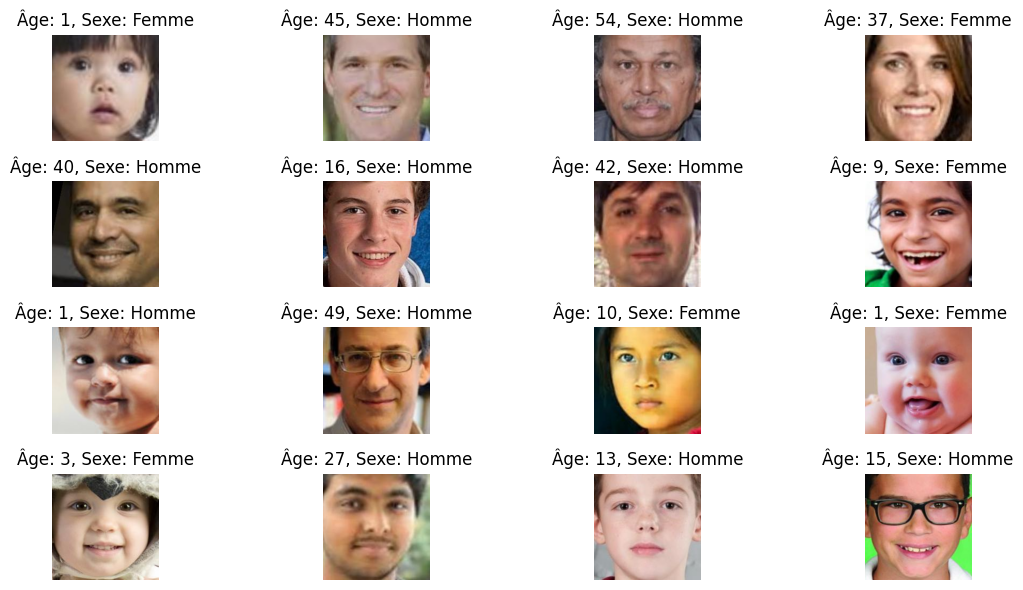

In [ ]:
def plot_images(data, num_images=16):
    """Affiche des images avec √¢ge et sexe."""
    fig, axes = plt.subplots(4, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        img_path, age, gender = data[i] # # R√©cup√®re le chemin de l‚Äôimage et les labels
        img = cv2.imread(img_path)  # charge l‚Äôimage en utilisant OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convertit l‚Äôimage en RGB pour qu‚Äôelle s‚Äôaffiche correctement avec matplotlib.
        axes[i].imshow(img) #  affiche l‚Äôimage dans le sous-graphique correspondant
        axes[i].set_title(f"√Çge: {age}, Sexe: {'Homme' if gender == 0 else 'Femme'}") # ajoute un titre avec √¢ge et sexe.
        axes[i].axis("off") # supprime les axes pour une meilleure visibilit√©.

    plt.tight_layout()
    plt.show()

# Afficher les images
plot_images(data)



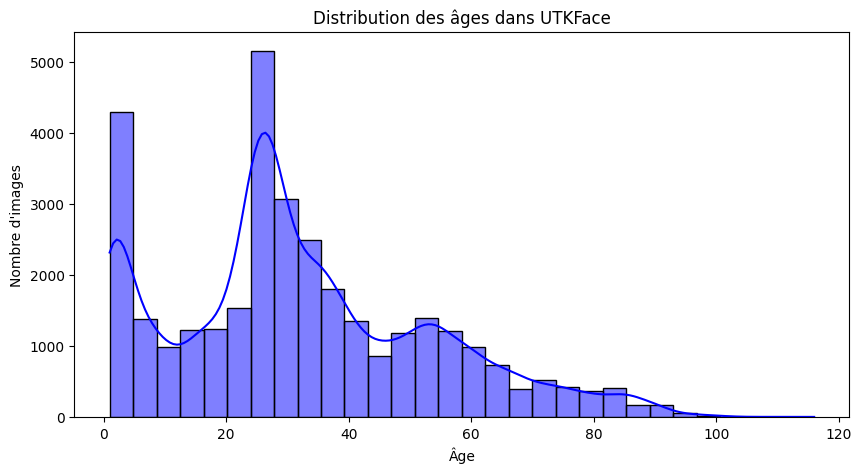

<ipython-input-12-2ea13bbe5ca8>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=genders, palette="coolwarm")


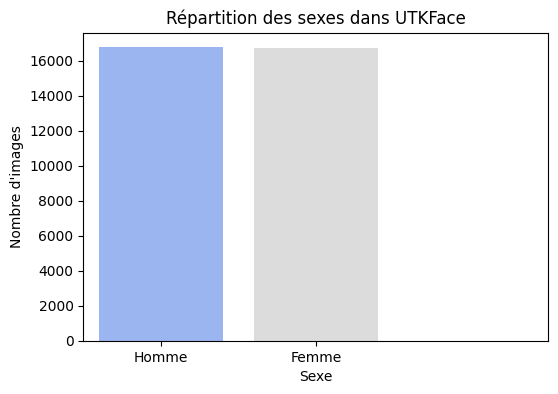

In [ ]:
# Extraire les √¢ges et sexes
ages = [int(age) for _, age, _ in data]
genders = [int(gender) for _, _, gender in data]

# Distribution des √¢ges
plt.figure(figsize=(10, 5))
sns.histplot(ages, bins=30, kde=True, color="blue")
plt.xlabel("√Çge")
plt.ylabel("Nombre d'images")
plt.title("Distribution des √¢ges dans UTKFace")
plt.show()

# Distribution des sexes
plt.figure(figsize=(6, 4))
sns.countplot(x=genders, palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Homme", "Femme"])
plt.xlabel("Sexe")
plt.ylabel("Nombre d'images")
plt.title("R√©partition des sexes dans UTKFace")
plt.show()


# PREPARATION DES DONNEES

In [ ]:
df_original = pd.DataFrame(data, columns=["image_path", "age", "gender"])
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33488 entries, 0 to 33487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  33488 non-null  object
 1   age         33488 non-null  object
 2   gender      33488 non-null  object
dtypes: object(3)
memory usage: 785.0+ KB


In [ ]:
df_original.head()

image_path age gender
0  /content/UTKFace/crop_part1/1_1_2_201612191935...   1      1
1  /content/UTKFace/crop_part1/45_0_0_20170104202...  45      0
2  /content/UTKFace/crop_part1/54_0_3_20170104220...  54      0
3  /content/UTKFace/crop_part1/37_1_0_20170105170...  37      1
4  /content/UTKFace/crop_part1/40_0_4_20170104204...  40      0

In [ ]:
nb_doublons=df_original.duplicated().sum()

In [ ]:
int(nb_doublons)

0

In [ ]:
unique_genders = df_original["gender"].nunique()
print("Nombre de valeurs uniques dans la colonne gender :", unique_genders)

Nombre de valeurs uniques dans la colonne gender : 3


In [ ]:
unique_values = df_original["gender"].unique()
print("Valeurs uniques dans la colonne gender :", unique_values)


Valeurs uniques dans la colonne gender : [1 0 3]


In [ ]:
# Supprimer les lignes o√π la colonne "gender" contient la valeur 3
df = df_original[df_original["gender"] != 3]

In [ ]:
df.shape
df["age"] = df["age"].astype(int)
df["gender"] = df["gender"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33487 entries, 0 to 33487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  33487 non-null  object
 1   age         33487 non-null  int64 
 2   gender      33487 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


<ipython-input-15-b36f1723c1b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age"] = df["age"].astype(int)
<ipython-input-15-b36f1723c1b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gender"] = df["gender"].astype(int)


In [ ]:
unique_genders = df["gender"].nunique()
print("Nombre de valeurs uniques dans la colonne gender :", unique_genders)

Nombre de valeurs uniques dans la colonne gender : 2


##  Analyse des dimensions des images



In [ ]:
image_shapes = []
for img_path in df["image_path"].sample(30000):  # Tester sur 30000 images al√©atoires
    img = cv2.imread(img_path)
    if img is not None:
        image_shapes.append(img.shape[:2])  # Hauteur, Largeur

# Convertir en DataFrame et voir les tailles les plus fr√©quentes
shape_df = pd.DataFrame(image_shapes, columns=["Height", "Width"])
print(shape_df.value_counts().head(10))  # Voir les 10 tailles d'image les plus fr√©quentes
print("Les images sont toutes de taille 200x200 ‚ÜíOn va redimensioner en fonction du mod√®le choisi")


Height  Width
200     200      30000
Name: count, dtype: int64
Les images sont toutes de taille 200x200 ‚ÜíOn va redimensioner en fonction du mod√®le choisi


## Cr√©ation de tranches d‚Äô√¢ges (binned classes)

<ipython-input-23-773a7c3fb274>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group"] = pd.cut(df["age"], bins=np.arange(0, 101, 10))
<ipython-input-23-773a7c3fb274>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_distribution.index.astype(str), y=age_distribution.values, palette="Blues")


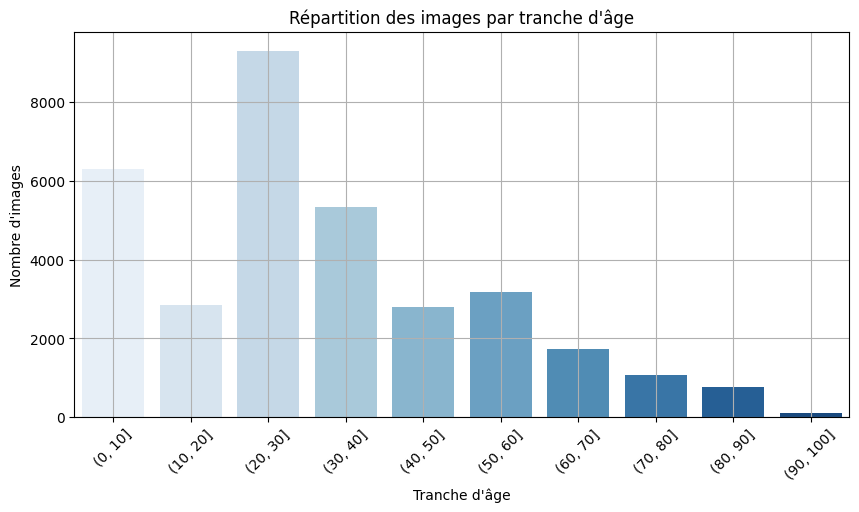

In [ ]:
# les √¢ges par tranche de 10 ans
df["age_group"] = pd.cut(df["age"], bins=np.arange(0, 101, 10))

#  le nombre d'images par tranche d'√¢ge
age_distribution = df["age_group"].value_counts().sort_index()

# Afficher les r√©sultats
plt.figure(figsize=(10, 5))
sns.barplot(x=age_distribution.index.astype(str), y=age_distribution.values, palette="Blues")
plt.xlabel("Tranche d'√¢ge")
plt.ylabel("Nombre d'images")
plt.title("R√©partition des images par tranche d'√¢ge")
plt.xticks(rotation=45)
plt.grid()
plt.show()


## R√©partition du sexe par tranche d'√¢ge

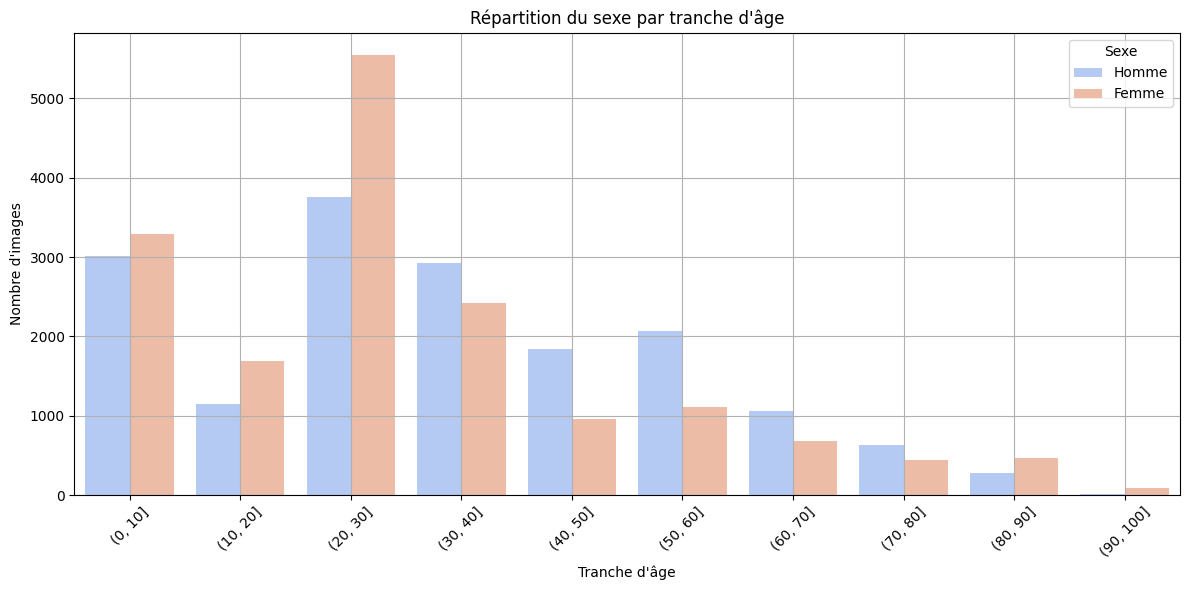

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="age_group", hue="gender", palette="coolwarm")
plt.xlabel("Tranche d'√¢ge")
plt.ylabel("Nombre d'images")
plt.title("R√©partition du sexe par tranche d'√¢ge")
plt.xticks(rotation=45)
plt.legend(title="Sexe", labels=["Homme", "Femme"])
plt.tight_layout()
plt.grid()
plt.show()


## Heatmap √¢ge √ó sexe (valeurs absolues ou normalis√©es)

<ipython-input-25-9bc3ce46c1d3>:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(heat_df, index="age_bin", columns="gender", values="image_path", aggfunc="count").fillna(0)


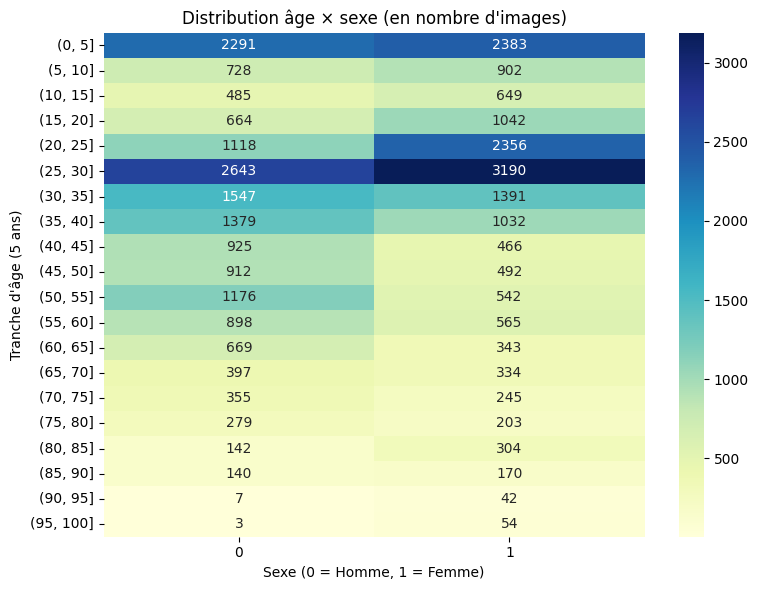

In [ ]:
heat_df = df.copy()
heat_df["age_bin"] = pd.cut(heat_df["age"], bins=np.arange(0, 101, 5))

pivot = pd.pivot_table(heat_df, index="age_bin", columns="gender", values="image_path", aggfunc="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Distribution √¢ge √ó sexe (en nombre d'images)")
plt.xlabel("Sexe (0 = Homme, 1 = Femme)")
plt.ylabel("Tranche d'√¢ge (5 ans)")
plt.tight_layout()
plt.show()


#  DECOUPAGE DU DATASET EN ENSEMBLE D'APPRENTISSAGE , VALIDATION , ET TEST .

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1997)

# Validation 10% du total depuis train

df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=1997)

# Affichage des tailles
print(f"Train : {len(df_train)} images")
print(f"Validation : {len(df_val)} images")
print(f"Test : {len(df_test)} images")

Train : 24110 images
Validation : 2679 images
Test : 6698 images


# Pr√©traitement et Data Augmentation

In [ ]:
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [ ]:
# Transformations pour TRAIN (avec Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # Redimensionne les images en 224x224 pixels (format standard)
    transforms.RandomHorizontalFlip(p=0.5), # Flip horizontal al√©atoire avec 50% de probabilit√© (pour augmenter les donn√©es)
    transforms.RandomRotation(20),  # Rotation al√©atoire jusqu'√† 20 degr√©s (augmentation des donn√©es)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # Recadrage al√©atoire pour zoomer l√©g√®rement sur l'image, augmente diversit√©
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Modifie al√©atoirement luminosit√© et contraste, am√©liore robustesse
    transforms.ToTensor(),  # Conversion de l'image PIL en Tensor PyTorch (format utilisable par PyTorch)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalisation des pixels (valeurs entre -1 et 1)
])

# D√©finition des transformations pour validation et test (PAS de Data Augmentation, seulement pr√©traitement basique)
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),  # Correction ici : Il y avait une erreur (224,2), on redimensionne en (224,224) pixels
    transforms.ToTensor(), # Conversion en tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # M√™me normalisation que pour train, obligatoire pour coh√©rence
])

# CONSTRUCTION DES DATASET PERSONNALISES ET DES DATALOADER

Charge les donn√©es en mini-batchs ‚Üí Optimise l‚Äôentra√Ænement sur GPU.

- Permet le m√©lange al√©atoire (shuffle=True) ‚Üí √âvite les biais d‚Äôapprentissage.
- G√®re les images volumineuses ‚Üí Charge les donn√©es en m√©moire par petits morceaux, au lieu de tout charger d‚Äôun coup.
- Facilite le parall√©lisme (num_workers) ‚Üí Acc√©l√®re le chargement des donn√©es.

In [ ]:
# Classe personnalis√©e pour charger efficacement les images et labels
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

      # R√©cup√©ration du chemin d'image, √¢ge et sexe correspondant √† l'index demand√©
        img_path, age, gender = self.df.iloc[idx]["image_path"], self.df.iloc[idx]["age"], self.df.iloc[idx]["gender"]
        image = Image.open(img_path).convert("RGB")

       # Ouverture et conversion de l'image en format RGB
        if self.transform:
            image = self.transform(image)


        # labels = torch.tensor([age, gender], dtype=torch.float32)
        return image, {"age": torch.tensor(age, dtype=torch.float32),
               "gender": torch.tensor(gender, dtype=torch.float32)}


In [ ]:
# Cr√©ation des datasets  avec transformations sp√©cifiques
train_dataset = UTKFaceDataset(df_train, transform=train_transforms)
val_dataset = UTKFaceDataset(df_val, transform=test_transforms)
test_dataset = UTKFaceDataset(df_test, transform=test_transforms)

# Cr√©ation des DataLoaders pour charger les images par batch durant l'entra√Ænement
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Les DataLoaders sont pr√™ts ")


Les DataLoaders sont pr√™ts 


* R√©sum√© : Pr√©paration des donn√©es  

 √Ä ce stade, les donn√©es ont √©t√© rigoureusement pr√©par√©es :
 1. Nettoyage : suppression des valeurs aberrantes (e.g., gender = 3)
 2. Exploration : visualisation des distributions (√¢ge, sexe, tranches d‚Äô√¢ge)
 3. D√©coupage : split en Train (72%), Validation (8%), Test (20%)
 4. Pr√©traitement :
    - Normalisation des images (pixels entre -1 et 1)
    - Redimensionnement uniforme √† 224√ó224
    - Data Augmentation appliqu√©e uniquement sur le train (flip, rotation, jitter)

 Les donn√©es sont donc pr√™tes √† √™tre inject√©es dans un mod√®le CNN.




 Choix des architectures :
 Nous avons d√©cid√© d‚Äôexp√©rimenter avec deux mod√®les pr√©-entra√Æn√©s :
 - RESNET18 : l√©ger, rapide, efficace pour un premier benchmark
 - InceptionV3 : plus profond, adapt√© aux t√¢ches complexes (multit√¢che, haute pr√©cision)

  √âtape suivante : d√©finition et adaptation des mod√®les √† notre t√¢che de pr√©diction d‚Äô√¢ge (r√©gression)
     et de sexe (classification binaire).

# PARTIE 2

# RESNET18 :
- Dans  notre cas on garde les premi√®res couches, mais on remplace la derni√®re couche (Fully Connected) pour l‚Äôadapter √† notre t√¢che.

Mais on se pose la question de hyper-parametres pour notre mod√®le .

Donc on teste et compare les performances de deux optimiseurs, SGD et Adam, avec diff√©rents learning rates

# Refacto :  
Probl√®me : Le mod√®le ResNet18 √©tait cr√©√© une seule fois et r√©utilis√© pour toutes les combinaisons (optimiseur, learning rate).

Cela causait un biais d'apprentissage, car chaque nouveau test b√©n√©ficiait des poids d√©j√† modifi√©s par les tests pr√©c√©dents.

R√©sultat : les pertes moyennes compar√©es √©taient fauss√©es, et le meilleur couple semblait meilleur simplement car il passait en dernier.

La correction a consist√© √† cr√©er un nouveau mod√®le vierge √† chaque combinaison via une fonction create_model().

Cela garantit que chaque test est ind√©pendant, reproductible, et scientifiquement valide.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

def create_model():
    """Cr√©e un nouveau mod√®le ResNet18 adapt√© √† la double t√¢che √¢ge + sexe."""
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 1 sortie √¢ge (r√©gression), 1 sortie sexe (classification)
    )
    return model

# Fonctions de perte
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# Param√®tres
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}

for opt_name in ["SGD", "Adam"]:
    for lr in learning_rates:
        print(f"\nüîÅ {opt_name} | Learning Rate: {lr}")

        # Cr√©er un nouveau mod√®le √† chaque combinaison
        model = create_model().to(device)

        # Optimiseur
        if opt_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        else:
            optimizer = optim.Adam(model.parameters(), lr=lr)

        # Entra√Ænement (1 √©poque pour test de perf)
        model.train()
        total_loss = 0.0

        for images, ages, genders in tqdm(train_loader):
            images, ages, genders = images.to(device), ages.to(device), genders.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # S√©paration des sorties
            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            # Pertes
            loss_age = criterion_age(predicted_age, ages)
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.5 * loss_age + loss_gender

            # Backprop
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        results[f"{opt_name}_lr_{lr}"] = avg_loss
        print(f"üìâ Moyenne des pertes : {avg_loss:.4f}")

# R√©sum√© des performances
print("\nüìä R√©sultats des configurations :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



üîÅ SGD | Learning Rate: 0.001


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 44.7M/44.7M [00:00<00:00, 180MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:14<00:00,  3.88it/s]


üìâ Moyenne des pertes : 97.8058

üîÅ SGD | Learning Rate: 0.0001


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:16<00:00,  3.85it/s]


üìâ Moyenne des pertes : 90.1394

üîÅ SGD | Learning Rate: 1e-05


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:12<00:00,  3.91it/s]


üìâ Moyenne des pertes : 270.4876

üîÅ SGD | Learning Rate: 1e-06


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:14<00:00,  3.88it/s]


üìâ Moyenne des pertes : 726.3594

üîÅ Adam | Learning Rate: 0.001


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:21<00:00,  3.75it/s]


üìâ Moyenne des pertes : 87.2769

üîÅ Adam | Learning Rate: 0.0001


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:19<00:00,  3.77it/s]


üìâ Moyenne des pertes : 106.0010

üîÅ Adam | Learning Rate: 1e-05


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:15<00:00,  3.87it/s]


üìâ Moyenne des pertes : 478.3448

üîÅ Adam | Learning Rate: 1e-06


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:25<00:00,  3.68it/s]

üìâ Moyenne des pertes : 719.9356

üìä R√©sultats des configurations :
SGD_lr_0.001: 97.8058
SGD_lr_0.0001: 90.1394
SGD_lr_1e-05: 270.4876
SGD_lr_1e-06: 726.3594
Adam_lr_0.001: 87.2769
Adam_lr_0.0001: 106.0010
Adam_lr_1e-05: 478.3448
Adam_lr_1e-06: 719.9356


- Pour l'optimiseur SGD le meilleure learning rate est de 1e-4.
- Pour l'optimiseur ADAM le meilleure learning rate de 1e-3.

#Je regarde le momentum a 0.1 pour SGD pour Resnet18

Momentum :  M√©thode souvent utilis√©e avec l'optimizer SGD  pour aider le mod√®le √† converger plus rapidement et de fa√ßon plus stable pendant l‚Äôentra√Ænement.

Attention : n√©ccessite beacoup de reglage manuel

In [ ]:
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    )
    return model

momentum = 0.1
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
results = {}

for lr in learning_rates:
    print(f"\n Testing SGD | LR={lr}, Momentum={momentum}")

    #  Nouveau mod√®le vierge √† chaque test
    model = create_model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    model.train()
    total_loss = 0.0

    for images, ages, genders in tqdm(train_loader):
        images, ages, genders = images.to(device), ages.to(device), genders.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"SGD_lr_{lr}_momentum_{momentum}"] = avg_loss
    print(f" Moyenne des pertes : {avg_loss:.4f}")

# R√©sum√©
print("\n R√©sultats finaux :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



 Testing SGD | LR=0.001, Momentum=0.1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:11<00:00,  3.93it/s]


 Moyenne des pertes : 101.4330

 Testing SGD | LR=0.0001, Momentum=0.1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:10<00:00,  3.97it/s]


 Moyenne des pertes : 90.3730

 Testing SGD | LR=1e-05, Momentum=0.1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:11<00:00,  3.95it/s]


 Moyenne des pertes : 267.3931

 Testing SGD | LR=1e-06, Momentum=0.1


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:12<00:00,  3.93it/s]

 Moyenne des pertes : 738.9205

 R√©sultats finaux :
SGD_lr_0.001_momentum_0.1: 101.4330
SGD_lr_0.0001_momentum_0.1: 90.3730
SGD_lr_1e-05_momentum_0.1: 267.3931
SGD_lr_1e-06_momentum_0.1: 738.9205


#On test SGD avec learning rate de 0.9

In [ ]:
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 2 sorties : √¢ge et sexe
    )
    return model

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
results = {}

# === Boucle d'exp√©rimentation
for lr in learning_rates:
    print(f"\n Testing SGD with a momentum of 0.9 | LR={lr}")

    model = create_model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum =0.9)
    model.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"SGD_lr_{lr}_momentum{0.9}"] = avg_loss
    print(f" Moyenne des pertes : {avg_loss:.4f}")

# R√©sum√©
print("\n R√©sultats des tests SGD :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



 Testing SGD with a momentum of 0.9 | LR=0.001


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:12<00:00,  3.92it/s]


 Moyenne des pertes : 263.1720

 Testing SGD with a momentum of 0.9 | LR=0.0001


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:12<00:00,  3.92it/s]


 Moyenne des pertes : 85.9625

 Testing SGD with a momentum of 0.9 | LR=1e-05


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:10<00:00,  3.95it/s]


 Moyenne des pertes : 100.3248

 Testing SGD with a momentum of 0.9 | LR=1e-06


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:09<00:00,  3.98it/s]

 Moyenne des pertes : 322.3187

 R√©sultats des tests Adam :
SGD_lr_0.001_momentum0.9: 263.1720
SGD_lr_0.0001_momentum0.9: 85.9625
SGD_lr_1e-05_momentum0.9: 100.3248
SGD_lr_1e-06_momentum0.9: 322.3187


* Comparaison des pertes moyennes par m√©thode (1 epoch)

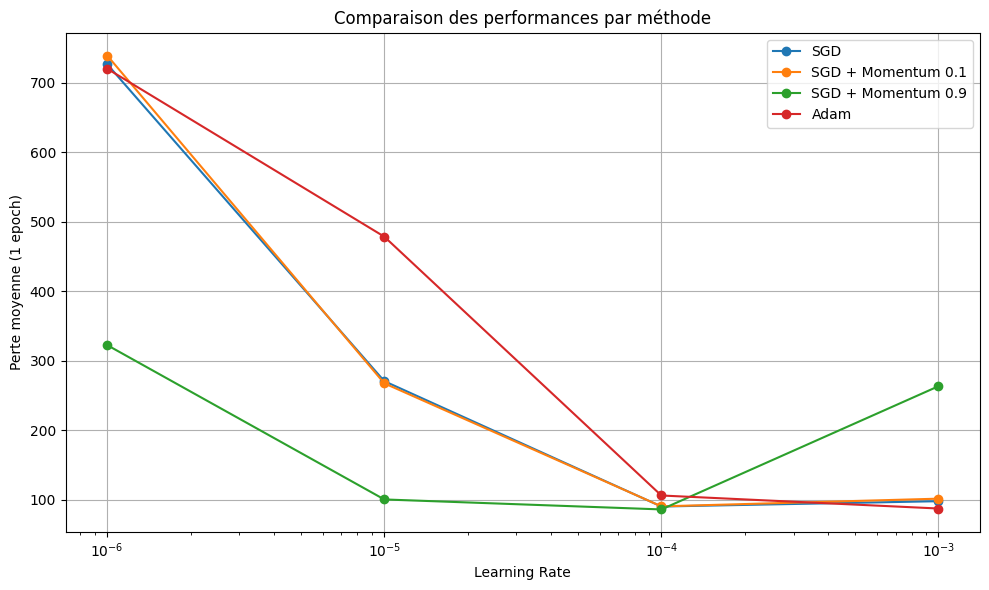

In [ ]:
# Courbes des pertes pour chaque m√©thode
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]

# Donn√©es r√©cup√©r√©es depuis tes logs
sgd_losses =     [97.8058, 90.1394, 270.4876, 726.3594]
sgd_mom_1_losses = [101.4330, 90.3730, 267.3931, 738.9205]
sgd_mom_9_losses =[263.17, 85.96, 100.32, 322.3187]
adam_losses =    [87.2769, 106.0010, 478.3448, 719.9356]

# Tracer le lineplot
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, sgd_losses, label="SGD", marker='o')
plt.plot(learning_rates, sgd_mom_1_losses, label="SGD + Momentum 0.1", marker='o')
plt.plot(learning_rates, sgd_mom_9_losses, label="SGD + Momentum 0.9", marker='o')
plt.plot(learning_rates, adam_losses, label="Adam", marker='o')

# Log scale pour x car les LR varient beaucoup
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Perte moyenne (1 epoch)")
plt.title("Comparaison des performances par m√©thode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Commentaire : Le mod√®le ResNet18 obtient sa meilleure performance avec Adam (lr=1e-3).
SGD + momentum n‚Äôa pas apport√© d‚Äôam√©lioration significative dans ce cas, mais reste plus stable √† bas learning rate. Cependant le SGD pour un momentum de 0.9, on peut remarquer qu'il a un comportement different, mais 1e-4 reste le meilleure learning rate.

# REFACTO


* Adam : con√ßu pour √™tre auto-r√©gulateur, pas de momentum

In [ ]:
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 2 sorties : √¢ge et sexe
    )
    return model

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
results = {}

# === Boucle d'exp√©rimentation
for lr in learning_rates:
    print(f"\n Testing Adam | LR={lr}")

    model = create_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"Adam_lr_{lr}"] = avg_loss
    print(f" Moyenne des pertes : {avg_loss:.4f}")

# R√©sum√©
print("\n R√©sultats des tests Adam :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



 Testing Adam | LR=0.001


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:13<00:00,  3.89it/s]


 Moyenne des pertes : 86.5082

 Testing Adam | LR=0.002


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:23<00:00,  3.71it/s]


 Moyenne des pertes : 108.6181

 Testing Adam | LR=0.003


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:14<00:00,  3.87it/s]


 Moyenne des pertes : 151.4920

 Testing Adam | LR=0.004


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:17<00:00,  3.82it/s]


 Moyenne des pertes : 137.2504

 Testing Adam | LR=0.005


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:34<00:00,  3.51it/s]


 Moyenne des pertes : 187.0613

 Testing Adam | LR=0.006


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:17<00:00,  3.81it/s]


 Moyenne des pertes : 166.3480

 Testing Adam | LR=0.007


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:17<00:00,  3.81it/s]


 Moyenne des pertes : 237.6608

 Testing Adam | LR=0.008


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:17<00:00,  3.82it/s]


 Moyenne des pertes : 199.7856

 Testing Adam | LR=0.009


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:16<00:00,  3.84it/s]

 Moyenne des pertes : 164.6275

 R√©sultats des tests Adam :
Adam_lr_0.001: 86.5082
Adam_lr_0.002: 108.6181
Adam_lr_0.003: 151.4920
Adam_lr_0.004: 137.2504
Adam_lr_0.005: 187.0613
Adam_lr_0.006: 166.3480
Adam_lr_0.007: 237.6608
Adam_lr_0.008: 199.7856
Adam_lr_0.009: 164.6275


Pour ADAM, le meilleure learnig rate est 0.001

 Meilleure config Adam : lr=0.0006 avec 78.9 de perte moyenne

In [ ]:
# === Fonction de cr√©ation du mod√®le ===
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # Sorties : √¢ge, sexe
    )
    return model

# === Param√®tres ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
momentum = 0.9
learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
results = {}

# === Boucle de test pour chaque learning rate ===
for lr in learning_rates:
    print(f"\nTesting SGD | LR={lr}, Momentum={momentum}")

    model = create_model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages)
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    results[f"SGD_lr_{lr}_momentum_{momentum}"] = avg_loss
    print(f"Moyenne des pertes : {avg_loss:.4f}")

# === R√©sum√© des performances
print("\nüîé R√©sultats finaux :")
for config, loss in results.items():
    print(f"{config}: {loss:.4f}")



Testing SGD | LR=0.0001, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:26<00:00,  3.65it/s]


Moyenne des pertes : 87.6942

Testing SGD | LR=0.0002, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:19<00:00,  3.77it/s]


Moyenne des pertes : 114.0808

Testing SGD | LR=0.0003, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:11<00:00,  3.93it/s]


Moyenne des pertes : 123.2061

Testing SGD | LR=0.0004, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:11<00:00,  3.93it/s]


Moyenne des pertes : 198.7964

Testing SGD | LR=0.0005, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:10<00:00,  3.95it/s]


Moyenne des pertes : 232.7703

Testing SGD | LR=0.0006, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:11<00:00,  3.93it/s]


Moyenne des pertes : 239.0551

Testing SGD | LR=0.0007, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:10<00:00,  3.96it/s]


Moyenne des pertes : 258.4304

Testing SGD | LR=0.0008, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:10<00:00,  3.95it/s]


Moyenne des pertes : 229.5251

Testing SGD | LR=0.0009, Momentum=0.9


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 754/754 [03:23<00:00,  3.71it/s]

Moyenne des pertes : 265.1835

üîé R√©sultats finaux :
SGD_lr_0.0001_momentum_0.9: 87.6942
SGD_lr_0.0002_momentum_0.9: 114.0808
SGD_lr_0.0003_momentum_0.9: 123.2061
SGD_lr_0.0004_momentum_0.9: 198.7964
SGD_lr_0.0005_momentum_0.9: 232.7703
SGD_lr_0.0006_momentum_0.9: 239.0551
SGD_lr_0.0007_momentum_0.9: 258.4304
SGD_lr_0.0008_momentum_0.9: 229.5251
SGD_lr_0.0009_momentum_0.9: 265.1835


Meilleure config SGD : lr=0.0001 avec 87.69 de perte moyenne

# Note :
Jusqu'a pr√©sent on a compar√© deux optimisateurs, Adam (avec ses param√®tres par d√©faut) et SGD avec momentum=0.9, en testant plusieurs valeurs de learning rate sur un mod√®le ResNet18 fine-tun√© pour pr√©dire l'√¢ge (r√©gression) et le sexe (classification binaire).

Pour Adam avec un learnig rate de 1e-3, on a que la perte moyenne de 86.5, alors que SGD a une perte de 87.7. Donc pour le SGD pour obrenir ces resulats ont demand√© beaacoup de reglage manuel.

#Dans cette partie on va se concentrer que sur l'InceptionV3

#Ici on modifie transform, notament le resize et la normalisation.
La normalisation est l√©gerement differente et aussi le crop.

In [ ]:
import torchvision.transforms as transforms

# Transformations pour TRAIN (avec Data Augmentation)
train_transforms_1 = transforms.Compose([
    transforms.Resize((299,299)), # Redimensionne les images en 299x299 pixels (format standard)
    transforms.RandomHorizontalFlip(p=0.5), # Flip horizontal al√©atoire avec 50% de probabilit√© (pour augmenter les donn√©es)
    transforms.RandomRotation(20),  # Rotation al√©atoire jusqu'√† 20 degr√©s (augmentation des donn√©es)
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # Recadrage al√©atoire pour zoomer l√©g√®rement sur l'image, augmente diversit√©
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Modifie al√©atoirement luminosit√© et contraste, am√©liore robustesse
    transforms.ToTensor(),  # Conversion de l'image PIL en Tensor PyTorch (format utilisable par PyTorch)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisation des pixels (valeurs entre -1 et 1)
])

## D√©finition des transformations pour validation et test (PAS de Data Augmentation, seulement pr√©traitement basique)
test_transforms_1 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(), # Conversion en tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # M√™me normalisation que pour train, obligatoire pour coh√©rence
])

In [ ]:
train_dataset_1 = UTKFaceDataset(df_train, transform=train_transforms_1)
val_dataset_1 = UTKFaceDataset(df_val, transform=test_transforms_1)
test_dataset_1 = UTKFaceDataset(df_test, transform=test_transforms_1)

# Cr√©ation des DataLoaders pour charger les images par batch durant l'entra√Ænement
train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=32, shuffle=False)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

print("Les DataLoaders sont pr√™ts ")


Les DataLoaders sont pr√™ts 


In [ ]:
len(train_dataset_1)

24110

# Echantillon de 20% de data train, puis comparaison des deux optimiseurs

# Refacto  :

In [ ]:
# === Sous-√©chantillonnage du dataset (20% des donn√©es d'entra√Ænement) ===
subset_size = int(len(train_dataset_1) * 0.2)
subset_indices = random.sample(range(len(train_dataset_1)), subset_size)
train_subset = Subset(train_dataset_1, subset_indices)
# Cr√©ation du DataLoader pour le sous-√©chantillon
subset_train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

# Fonction pour r√©initialiser le mod√®le aux poids initiaux d'InceptionV3
from torchvision.models import inception_v3, Inception_V3_Weights

In [ ]:
print(f"Entra√Æment sur 20% de la data train ({len(subset_train_loader.dataset)} √©chantillons).")


def reset_model():
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # 2 sorties : √¢ge et sexe
    )
    return inception.to(device)

# Transfert sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Fonctions de perte ===
criterion_age = nn.MSELoss()  # R√©gression pour l'√¢ge
criterion_gender = nn.BCEWithLogitsLoss()  # Classification pour le sexe

# === Valeurs d'apprentissage et optimisateurs ===
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]
results = {}

# === Boucle pour tester chaque combinaison ===
for opt_name in ["SGD", "Adam"]:
    print(f"Testing {opt_name} optimizer...")

    for lr in learning_rates:
        inception = reset_model()    # la fonction reset
        if opt_name == "SGD":
            optimizer = optim.SGD(inception.parameters(), lr=lr)
        else:
            optimizer = optim.Adam(inception.parameters(), lr=lr)

        print(f"Testing {opt_name} with learning rate {lr}...")

        inception.train()
        total_loss = 0.0

        for images, labels_dict in tqdm(subset_train_loader):
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)

            optimizer.zero_grad()
            outputs = inception(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Si Inception retourne (aux_logits, logits)

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100  # On divise par 100 car MSE tr√®s grande
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.5 * loss_age + loss_gender

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(subset_train_loader)
        results[f"{opt_name}_lr_{lr}"] = avg_loss
        print(f"Average Loss: {avg_loss}")


Entra√Æment sur 20% de la data train (4822 √©chantillons).
Testing SGD optimizer...
Testing SGD with learning rate 0.001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:43<00:00,  1.46it/s]


Average Loss: 8.002230966327996
Testing SGD with learning rate 0.0001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:43<00:00,  1.45it/s]


Average Loss: 8.247539008690032
Testing SGD with learning rate 1e-05...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:44<00:00,  1.45it/s]


Average Loss: 8.224739630490738
Testing SGD with learning rate 1e-06...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:44<00:00,  1.45it/s]


Average Loss: 8.332776044378218
Testing Adam optimizer...
Testing Adam with learning rate 0.001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:44<00:00,  1.44it/s]


Average Loss: 1.9760578764195473
Testing Adam with learning rate 0.0001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:44<00:00,  1.44it/s]


Average Loss: 3.4653355060823707
Testing Adam with learning rate 1e-05...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:44<00:00,  1.44it/s]


Average Loss: 7.8749219029155
Testing Adam with learning rate 1e-06...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:44<00:00,  1.44it/s]

Average Loss: 8.256263571859195


## SGD vs Adam - InceptionV3 (20% Training Set)

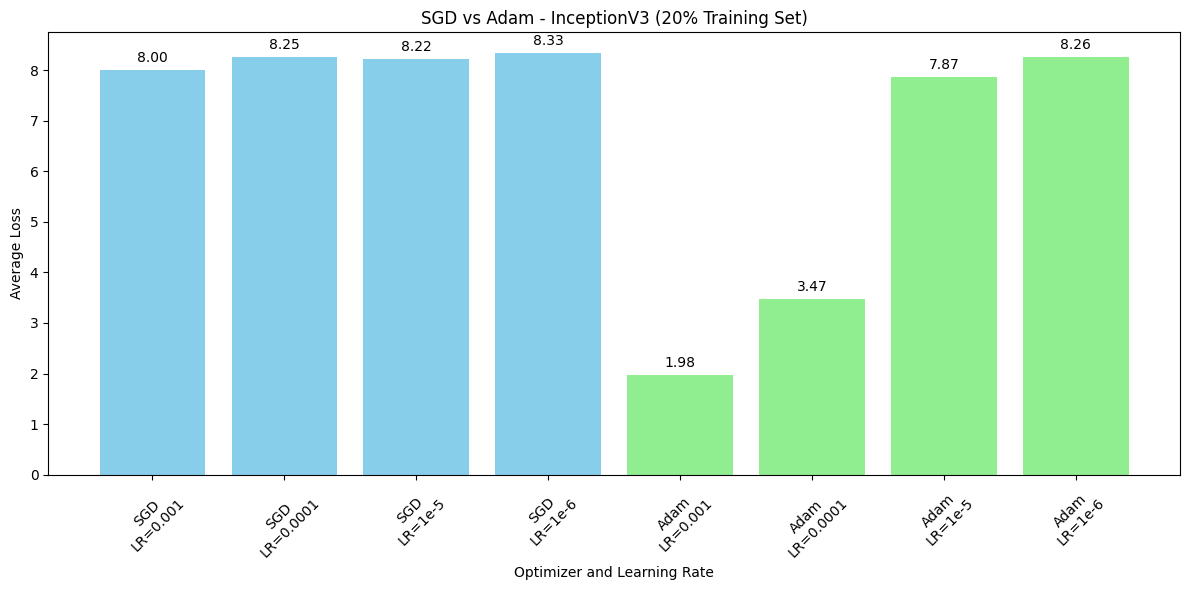

In [ ]:
# Donn√©es
optimizers = ['SGD', 'SGD', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam', 'Adam']
learning_rates = ['0.001', '0.0001', '1e-5', '1e-6', '0.001', '0.0001', '1e-5', '1e-6']
losses = [8.00, 8.25, 8.22, 8.33, 1.98, 3.47, 7.87, 8.26]

# Couleurs pour les barres
colors = ['skyblue' if opt == 'SGD' else 'lightgreen' for opt in optimizers]

# Cr√©ation du barplot
plt.figure(figsize=(12, 6))
bars = plt.bar([f'{opt}\nLR={lr}' for opt, lr in zip(optimizers, learning_rates)], losses, color=colors)

# Ajout des annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

# Param√®tres du graphique
plt.title("SGD vs Adam - InceptionV3 (20% Training Set)")
plt.ylabel("Average Loss")
plt.xlabel("Optimizer and Learning Rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Ce qu‚Äôil faut retenir de cette comparaison
 Adam (LR = 0.001) donne la meilleure performance avec une loss ‚âà 1.98, bien plus basse que n‚Äôimporte quel autre essai.

SGD stagne entre 8.00 et 8.33, quel que soit le learning rate ‚Üí il n'apprend presque rien dans ce setup.

Adam avec LR faible (1e-5 / 1e-6) ‚âà les performances de SGD ‚Üí sous-apprentissage (trop petit LR).

Adam est clairement plus adapt√© dans ce cas (InceptionV3 + multit√¢che √¢ge/genre sur UTKFace), sans tuning complexe.



#Ici a √©te definie la fonction reset, pour que le poids du mod√®le Inception soit reintialiser pour Adam.

#Ici je regarde SGD avec un momentum de 0.9

# Refacto :  

Ligne probl√©matique dans le code original :

optimizers = {"SGD": [optim.SGD(inception.parameters(), lr=lr, momentum=0.9) for lr in learning_rates]}


In [ ]:
# Affichage de la taille du sous-√©chantillon
print(f"Entra√Ænement sur 20% de la data train ({len(subset_train_loader.dataset)} √©chantillons).")

# Transfert sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonctions de perte
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# Learning rates √† tester
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

# Dictionnaire pour stocker les r√©sultats
results = {}

# Optimiseur √† tester : SGD avec momentum
opt_name = "SGD"
print(f"Testing {opt_name} optimizer...")

for lr in learning_rates:
    print(f"Testing {opt_name} with learning rate {lr}...")

    #  R√©initialisation compl√®te du mod√®le pour CHAQUE learning rate
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)  # Sorties : √¢ge et sexe
    )
    inception = inception.to(device)

    optimizer = optim.SGD(inception.parameters(), lr=lr, momentum=0.9)

    # Entra√Ænement
    inception.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(subset_train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = inception(images)

        # Si le mod√®le renvoie un tuple (cas d‚ÄôInceptionV3), on prend la sortie principale
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100  # MSE tr√®s grande sinon
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.5 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(subset_train_loader)
    results[f"{opt_name}_lr_{lr}"] = avg_loss
    print(f"Average Loss: {avg_loss:.4f}")

Entra√Ænement sur 20% de la data train (4822 √©chantillons).
Testing SGD optimizer...
Testing SGD with learning rate 0.001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:47<00:00,  1.40it/s]


Average Loss: 4.0678
Testing SGD with learning rate 0.0001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:55<00:00,  1.31it/s]


Average Loss: 8.1466
Testing SGD with learning rate 1e-05...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:45<00:00,  1.43it/s]


Average Loss: 8.2383
Testing SGD with learning rate 1e-06...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:41<00:00,  1.48it/s]

Average Loss: 8.2019


## SGD vs Adam - InceptionV3 (20% Training Set)

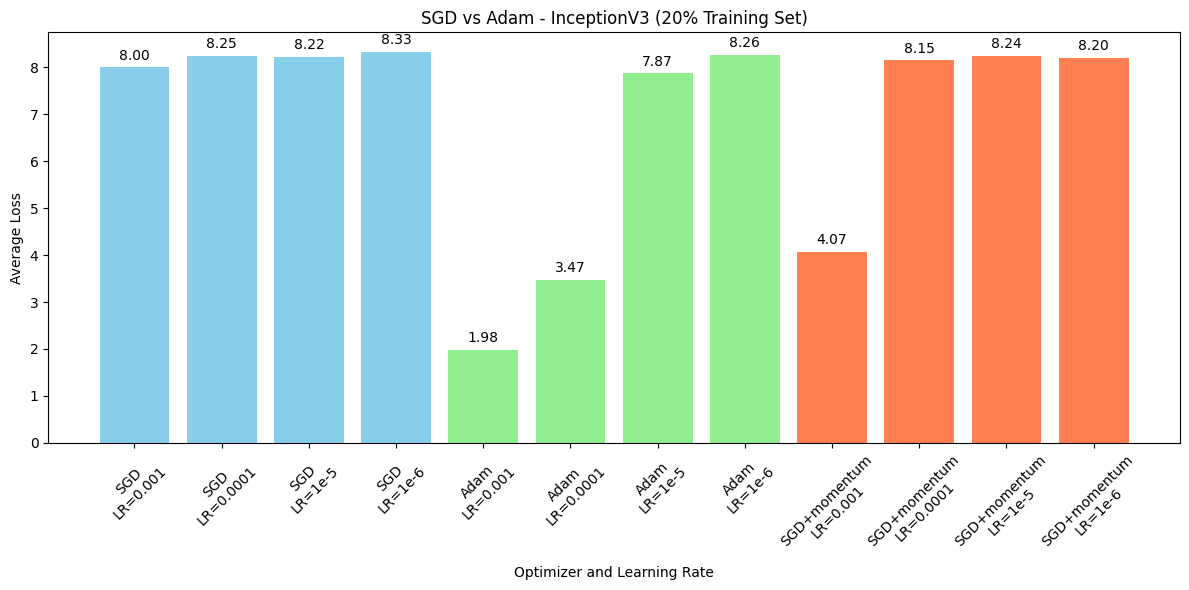

In [ ]:
# Donn√©es
optimizers = ['SGD', 'SGD', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam', 'Adam', 'SGD+momentum', 'SGD+momentum', 'SGD+momentum', 'SGD+momentum']
learning_rates = ['0.001', '0.0001', '1e-5', '1e-6'] * 3
losses = [8.00, 8.25, 8.22, 8.33, 1.98, 3.47, 7.87, 8.26, 4.0678,8.1466,8.2383,8.2019]

# Couleurs pour les barres
colors = ['skyblue' if opt == 'SGD' else 'coral' if opt == 'SGD+momentum' else 'lightgreen' for opt in optimizers]

# Cr√©ation du barplot
plt.figure(figsize=(12, 6))
bars = plt.bar([f'{opt}\nLR={lr}' for opt, lr in zip(optimizers, learning_rates)], losses, color=colors)

# Ajout des annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

# Param√®tres du graphique
plt.title("SGD vs Adam - InceptionV3 (20% Training Set)")
plt.ylabel("Average Loss")
plt.xlabel("Optimizer and Learning Rate")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


* On voit clarement une amelioration de SGD avec momentum ------> Sans momentum, SGD √©choue totalement ici

*  Adam est tr√®s performant √† 1e-3, mais se d√©grade fortement ensuite.

* On observe que SGD sans momentum est inefficace sur ce dataset avec InceptionV3.
* L'ajout de momentum (0.9) am√©liore nettement les performances √† LR=1e-3, mais reste loin des r√©sultats obtenus avec Adam.
* Adam √† LR=1e-3 surpasse tous les autres r√©glages, confirmant sa robustesse et efficacit√© en mode "plug & play".
‚û§ Pour ce cas pr√©cis, Adam reste le meilleur choix, mais SGD+momentum pourrait √™tre comp√©titif avec un meilleur tuning (scheduler, warmup, batch size...).



* ma note : 	Il faut toujours r√©initialiser les poids du mod√®le pour tester √©quitablement chaque learning rate.

le meilleur learning rate est clairement 0.001, pas 0.0001.
Et plus tu diminues le learning rate, moins le mod√®le converge, ce qui est logique sans "poids chauds".

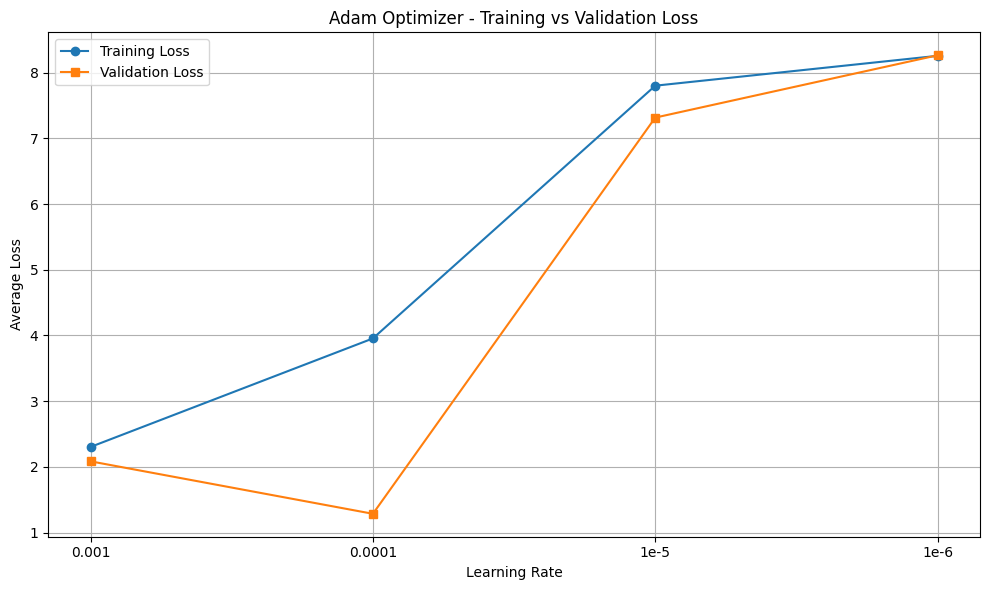

In [ ]:
# Donn√©es de pertes apr√®s correction
learning_rates = ["0.001", "0.0001", "1e-5", "1e-6"]
train_losses = [2.3040, 3.9552, 7.8005, 8.2550]
val_losses = [2.0855, 1.2872, 7.3151, 8.2635]

# Cr√©ation du graphique
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_losses, marker='o', label='Training Loss')
plt.plot(learning_rates, val_losses, marker='s', label='Validation Loss')
plt.xlabel("Learning Rate")
plt.ylabel("Average Loss")
plt.title("Adam Optimizer - Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


------> Apres refacto
√Ä 0.001, la perte d'entra√Ænement (2.30) et de validation (2.08) sont plus proches, ce qui traduit un mod√®le plus stable et mieux r√©gularis√©.

Les valeurs tr√®s faibles (1e-05 et 1e-06) montrent une stagnation, ce qui est attendu car le learning rate est trop bas pour converger efficacement.

 Conclusion : Le meilleur compromis ici est 0.001, car il permet un bon entra√Ænement sans sur-apprentissage, avec des pertes coh√©rentes sur le train et le val.
Il est donc erron√© de conclure que 0.0001 est la meilleure option √† partir de ces r√©sultats."

# Pond√©ration diff√©rente entre les deux pertes (0.7 * loss_age + loss_gender).

# Refacto

In [ ]:
#  Test affin√© du learning rate pour l‚Äôoptimiseur Adam (sur 20% des donn√©es)

print(f"Entra√Ænement sur 20% de la data train ({len(subset_train_loader.dataset)} √©chantillons).")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonctions de perte
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# Liste des learning rates √† tester
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]
results = {}

# Boucle d‚Äô√©valuation pour chaque learning rate
for lr in learning_rates:
    print(f"\n Testing Adam with learning rate {lr}...")

    # R√©initialisation du mod√®le √† chaque fois
    inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 2)
    )
    inception = inception.to(device)

    optimizer = optim.Adam(inception.parameters(), lr=lr)
    inception.train()
    total_loss = 0.0

    for images, labels_dict in tqdm(subset_train_loader):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)

        optimizer.zero_grad()
        outputs = inception(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.7 * loss_age + loss_gender  #  pond√©ration modifi√©e ici

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(subset_train_loader)
    results[f"Adam_lr_{lr}"] = avg_loss
    print(f"Average Loss: {avg_loss:.4f}")


Entra√Ænement sur 20% de la data train (4822 √©chantillons).

 Testing Adam with learning rate 0.001...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 104M/104M [00:00<00:00, 161MB/s] 
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:49<00:00,  1.37it/s]


Average Loss: 2.6382

 Testing Adam with learning rate 0.002...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:49<00:00,  1.38it/s]


Average Loss: 3.3287

 Testing Adam with learning rate 0.003...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:51<00:00,  1.35it/s]


Average Loss: 4.5495

 Testing Adam with learning rate 0.004...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:51<00:00,  1.35it/s]


Average Loss: 4.4055

 Testing Adam with learning rate 0.005...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:51<00:00,  1.35it/s]


Average Loss: 4.5434

 Testing Adam with learning rate 0.006...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:47<00:00,  1.40it/s]


Average Loss: 4.5128

 Testing Adam with learning rate 0.007...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:51<00:00,  1.36it/s]


Average Loss: 4.2658

 Testing Adam with learning rate 0.008...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:51<00:00,  1.35it/s]

Average Loss: 4.4532


 * Avant correction (pas de reset, poids biais√©s)
   Observation faussement optimiste : les pertes sont bien plus basses car les poids √©taient d√©j√† partiellement entra√Æn√©s.

 * Apr√®s correction (avec r√©initialisation + weights=DEFAULT)

√âvolution de la Loss Moyenne selon le Learning Rate (Adam, apr√®s correction)

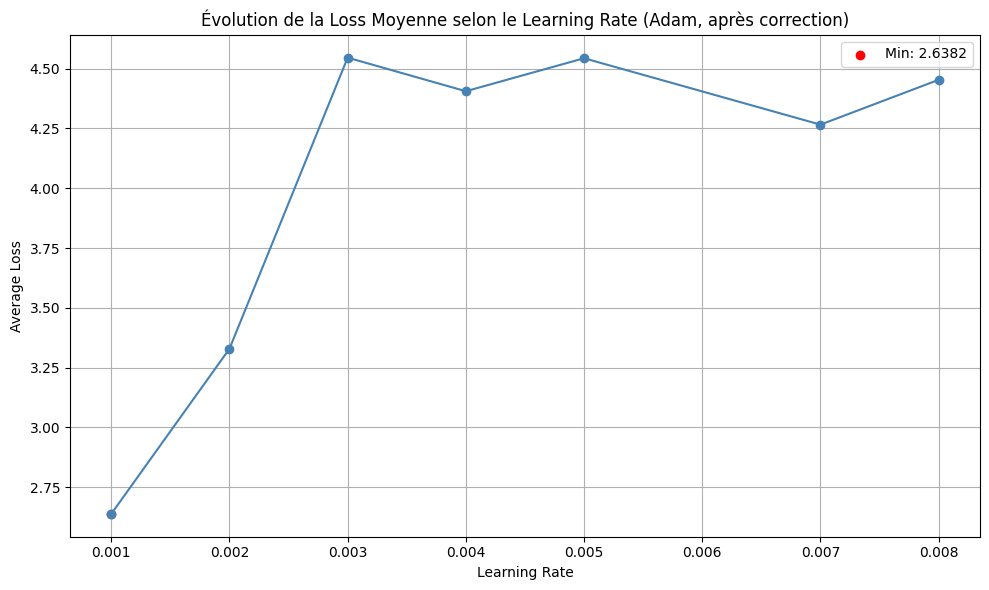

In [ ]:
import matplotlib.pyplot as plt

# Donn√©es initiales
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.000, 0.007, 0.008]
losses = [2.6382, 3.3287, 4.5459, 4.4055, 4.5434, 4.5128, 4.2658, 4.4532]

# Suppression de learning_rate = 0 si souhait√© (facultatif)
# Si tu veux le garder, ignore cette section
lr_losses = [(lr, loss) for lr, loss in zip(learning_rates, losses) if lr > 0]

# Tri des donn√©es par learning rate
lr_losses.sort()
sorted_learning_rates, sorted_losses = zip(*lr_losses)

# Cr√©ation du graphique
plt.figure(figsize=(10, 6))
plt.plot(sorted_learning_rates, sorted_losses, marker='o', linestyle='-', color='steelblue')
plt.title("√âvolution de la Loss Moyenne selon le Learning Rate (Adam, apr√®s correction)")
plt.xlabel("Learning Rate")
plt.ylabel("Average Loss")
plt.grid(True)

# Mise en √©vidence du point minimum
min_index = sorted_losses.index(min(sorted_losses))
plt.scatter(sorted_learning_rates[min_index], sorted_losses[min_index], color='red', label=f"Min: {sorted_losses[min_index]:.4f}")
plt.legend()

plt.tight_layout()
plt.show()


# Conclusion:
Plus le learning rate augmente, plus la perte moyenne augmente egalement. Donc le meilleure learning rate est de 1e-3.

# Tester l‚Äôimpact du taux de Dropout sur les performances du mod√®le InceptionV3
Le learning rate de 0.01 nous int√©resse.

In [ ]:
def train_model(dropout_rate, learning_rate=0.001):  # <== ici le lr est 0.001
    print(f"Testing dropout={dropout_rate} with learning rate {learning_rate}...")

    # Charger InceptionV3 pr√©-entra√Æn√©
    inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
    num_features = inception.fc.in_features

    # Remplacer la derni√®re couche Fully Connected avec le dropout variable
    inception.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, 2)
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception = inception.to(device)

    criterion_age = nn.MSELoss()
    criterion_gender = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

    inception.train()
    total_loss = 0.0

    for images, labels in tqdm(subset_train_loader):
        images = images.to(device)
        ages = labels["age"].to(device)
        genders = labels["gender"].to(device)

        optimizer.zero_grad()
        outputs = inception(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.7 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(subset_train_loader)
    print(f"Average Loss with dropout={dropout_rate}: {avg_loss}")
    return inception, avg_loss


def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0.0
    criterion_age = nn.MSELoss()
    criterion_gender = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            ages = labels["age"].to(device)
            genders = labels["gender"].to(device)

            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender

            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss


In [ ]:
dropouts = [0.3, 0.4]
results = {}

for d in dropouts:
    print(f"\n=== Training with dropout={d} ===")
    model, train_loss = train_model(d, learning_rate=0.001)
    val_loss = evaluate_model(model, val_loader_1)

    results[f"dropout_{d}"] = {
        "train_loss": train_loss,
        "val_loss": val_loss
    }

    print(f"Train Loss with dropout={d}: {train_loss:.4f}")
    print(f"Validation Loss with dropout={d}: {val_loss:.4f}")



=== Training with dropout=0.3 ===
Testing dropout=0.3 with learning rate 0.001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:55<00:00,  1.31it/s]


Average Loss with dropout=0.3: 2.6299302949021195


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:23<00:00,  3.59it/s]


Train Loss with dropout=0.3: 2.6299
Validation Loss with dropout=0.3: 1.6918

=== Training with dropout=0.4 ===
Testing dropout=0.4 with learning rate 0.001...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:47<00:00,  1.40it/s]


Average Loss with dropout=0.4: 2.9165631895823196


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:22<00:00,  3.70it/s]

Train Loss with dropout=0.4: 2.9166
Validation Loss with dropout=0.4: 1.7486


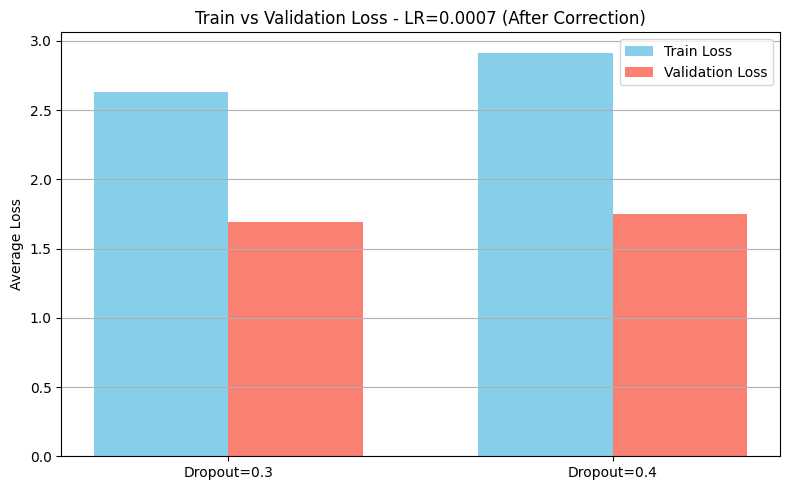

In [ ]:
# Donn√©es apr√®s correction
dropouts = [0.3, 0.4]
train_losses = [2.6299, 2.9166]
val_losses = [1.6918, 1.7486]

# Cr√©ation du graphique comparatif
x = range(len(dropouts))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - bar_width / 2 for i in x], train_losses, width=bar_width, label='Train Loss', color='skyblue')
plt.bar([i + bar_width / 2 for i in x], val_losses, width=bar_width, label='Validation Loss', color='salmon')

plt.xticks(x, [f'Dropout={d}' for d in dropouts])
plt.ylabel("Average Loss")
plt.title("Train vs Validation Loss - LR=0.0007 (After Correction)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()


Conclusion :
On remarque que les resulatats sont tr√©s proche, mais on va rester sur led dropout de 0.3.

# √âvaluation de la taille de la couche fully connected sur InceptionV3 avec Dropout et Adam



# Refacto

Entra√Ænement : loss = 0.5 * loss_age + loss_gender

Validation : loss = 0.7 * loss_age + loss_gender
üëâ Cela biaise un peu la comparaison entre train/val. Il vaudrait mieux garder les m√™mes pond√©rations dans les deux cas, sauf raison pr√©cise et justifi√©e.

In [ ]:
def train_and_evaluate_fully_connected(num_neurons_list, learning_rate, dropout_value, subset_train_loader, val_loader, criterion_age, criterion_gender, device):
    results = {}  # Stockage des r√©sultats pour chaque taille de couche FC

    for num_neurons in num_neurons_list:
        print(f"\nTesting Fully Connected Layer with {num_neurons} neurons...")

        # Charger un nouveau mod√®le InceptionV3 avec poids corrects
        inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)

        # Remplacer la derni√®re couche Fully Connected
        num_features = inception.fc.in_features
        inception.fc = nn.Sequential(
            nn.Linear(num_features, num_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(num_neurons, 2)  # 2 sorties : √¢ge et sexe
        )
        inception = inception.to(device)

        # Optimiseur
        optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

        # === Entra√Ænement ===
        inception.train()
        total_train_loss = 0.0

        for images, labels_dict in tqdm(subset_train_loader):
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)

            optimizer.zero_grad()
            outputs = inception(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender  # pond√©ration uniforme pour coh√©rence

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(subset_train_loader)

        # === Validation ===
        inception.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for images, labels_dict in val_loader:
                images = images.to(device)
                ages = labels_dict["age"].to(device)
                genders = labels_dict["gender"].to(device)

                outputs = inception(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                predicted_age = outputs[:, 0]
                predicted_gender = outputs[:, 1]

                loss_age = criterion_age(predicted_age, ages) / 100
                loss_gender = criterion_gender(predicted_gender, genders)
                loss = 0.7 * loss_age + loss_gender  # m√™me pond√©ration

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        results[f"{num_neurons}_neurons"] = {
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        }

        print(f"Average Training Loss for {num_neurons} neurons: {avg_train_loss:.4f}")
        print(f"Average Validation Loss for {num_neurons} neurons: {avg_val_loss:.4f}")

    return results


# === Hyperparam√®tres ===
num_neurons_list = [64, 128, 256]
learning_rate = 0.001  #  Meilleure valeur observ√©e pr√©c√©demment
dropout_value = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Fonctions de perte ===
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()

# === Appel de la fonction ===
results = train_and_evaluate_fully_connected(
    num_neurons_list=num_neurons_list,
    learning_rate=learning_rate,
    dropout_value=dropout_value,
    subset_train_loader=subset_train_loader,
    val_loader=val_loader_1,
    criterion_age=criterion_age,
    criterion_gender=criterion_gender,
    device=device
)

# === Affichage des r√©sultats finaux ===
print("\nR√©sultats finaux :")
for neurons, losses in results.items():
    print(f"{neurons}: Training Loss = {losses['train_loss']:.4f}, Validation Loss = {losses['val_loss']:.4f}")



Testing Fully Connected Layer with 64 neurons...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:52<00:00,  1.34it/s]


Average Training Loss for 64 neurons: 3.0327
Average Validation Loss for 64 neurons: 2.0064

Testing Fully Connected Layer with 128 neurons...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:56<00:00,  1.30it/s]


Average Training Loss for 128 neurons: 2.7549
Average Validation Loss for 128 neurons: 1.9199

Testing Fully Connected Layer with 256 neurons...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [01:56<00:00,  1.30it/s]


Average Training Loss for 256 neurons: 2.4605
Average Validation Loss for 256 neurons: 1.4895

R√©sultats finaux :
64_neurons: Training Loss = 3.0327, Validation Loss = 2.0064
128_neurons: Training Loss = 2.7549, Validation Loss = 1.9199
256_neurons: Training Loss = 2.4605, Validation Loss = 1.4895


 Sans pond√©ration uniforme, le mod√®le sur-optimisait la classification du sexe.

Avec pond√©ration uniforme, il apprend de fa√ßon plus √©quilibr√©e, au prix d‚Äôun l√©ger surco√ªt en loss, surtout pour l'√¢ge.

Le mod√®le √† 256 neurones reste le plus performant en validation dans les deux cas.

# Entra√Ænement final avec Early Stopping et √©valuation sur le test set

* Finalement on peut tester notre mod√®le.

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:24<00:00,  3.47it/s]


Epoch [1/15] - Train Loss: 1.6593, Val Loss: 0.9376
Validation Loss improved. Model saved at epoch 1.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.12it/s]


Epoch [2/15] - Train Loss: 1.0596, Val Loss: 0.7481
Validation Loss improved. Model saved at epoch 2.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.02it/s]


Epoch [3/15] - Train Loss: 0.9622, Val Loss: 0.6951
Validation Loss improved. Model saved at epoch 3.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.04it/s]


Epoch [4/15] - Train Loss: 0.8963, Val Loss: 0.7054
No improvement in Validation Loss for 1 epoch(s).


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.03it/s]


Epoch [5/15] - Train Loss: 0.8041, Val Loss: 0.6685
Validation Loss improved. Model saved at epoch 5.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.07it/s]


Epoch [6/15] - Train Loss: 0.7824, Val Loss: 0.7758
No improvement in Validation Loss for 1 epoch(s).


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.06it/s]


Epoch [7/15] - Train Loss: 0.7588, Val Loss: 0.6591
Validation Loss improved. Model saved at epoch 7.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.13it/s]


Epoch [8/15] - Train Loss: 0.7414, Val Loss: 0.6379
Validation Loss improved. Model saved at epoch 8.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:21<00:00,  3.97it/s]


Epoch [9/15] - Train Loss: 0.6771, Val Loss: 0.5639
Validation Loss improved. Model saved at epoch 9.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:21<00:00,  3.88it/s]


Epoch [10/15] - Train Loss: 0.6690, Val Loss: 0.5522
Validation Loss improved. Model saved at epoch 10.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:21<00:00,  3.92it/s]


Epoch [11/15] - Train Loss: 0.6447, Val Loss: 0.6887
No improvement in Validation Loss for 1 epoch(s).


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:21<00:00,  3.96it/s]


Epoch [12/15] - Train Loss: 0.6078, Val Loss: 0.5264
Validation Loss improved. Model saved at epoch 12.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.13it/s]


Epoch [13/15] - Train Loss: 0.5879, Val Loss: 0.5410
No improvement in Validation Loss for 1 epoch(s).


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:21<00:00,  4.00it/s]


Epoch [14/15] - Train Loss: 0.5793, Val Loss: 0.6118
No improvement in Validation Loss for 2 epoch(s).


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 84/84 [00:20<00:00,  4.07it/s]


Epoch [15/15] - Train Loss: 0.5553, Val Loss: 0.5005
Validation Loss improved. Model saved at epoch 15.
Best model reloaded for testing.


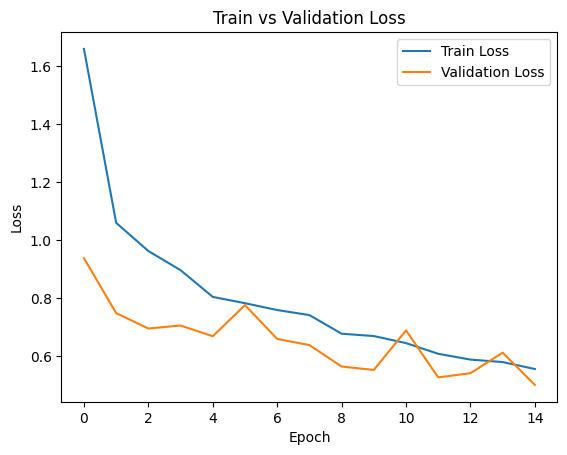


=== Test Set Final Results ===
Test Loss: 0.8599
Test Mae: 4.6480
Precision: 0.9063
Recall: 0.9425
F1 Score: 0.9241


In [ ]:
# === Param√®tres ===
num_epochs = 15
learning_rate = 0.001  # corrig√©: meilleure valeur observ√©e
dropout_rate = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Mod√®le InceptionV3 pr√©-entrai√Æn√© ===
inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
num_features = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(256, 2)
)
inception = inception.to(device)

# === Pertes et optimiseur ===
criterion_age = nn.MSELoss()
criterion_gender = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(inception.parameters(), lr=learning_rate)

# === Early Stopping ===
patience = 3
best_val_loss = float('inf')
no_improve_count = 0
model_path = "best_inception_model.pth"

train_losses, val_losses = [], []

# === Entra√Ænement ===
for epoch in range(num_epochs):
    inception.train()
    total_train_loss = 0.0

    for images, labels_dict in tqdm(train_loader_1):
        images = images.to(device)
        ages = labels_dict["age"].to(device)
        genders = labels_dict["gender"].to(device)


        optimizer.zero_grad()
        outputs = inception(images)
        if isinstance(outputs, tuple): outputs = outputs[0]

        predicted_age = outputs[:, 0]
        predicted_gender = outputs[:, 1]

        loss_age = criterion_age(predicted_age, ages) / 100
        loss_gender = criterion_gender(predicted_gender, genders)
        loss = 0.7 * loss_age + loss_gender

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader_1)
    train_losses.append(avg_train_loss)

    # === Validation ===
    inception.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels_dict in tqdm(val_loader_1):
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)


            outputs = inception(images)
            if isinstance(outputs, tuple): outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = outputs[:, 1]

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader_1)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_count = 0
        torch.save(inception.state_dict(), model_path)
        print(f"Validation Loss improved. Model saved at epoch {epoch+1}.")
    else:
        no_improve_count += 1
        print(f"No improvement in Validation Loss for {no_improve_count} epoch(s).")
        if no_improve_count >= patience:
            print(f"Early Stopping triggered at epoch {epoch+1}.")
            break

# === R√©cup√©rer le meilleur mod√®le ===
inception.load_state_dict(torch.load(model_path))
print("Best model reloaded for testing.")

# === Visualisation des pertes ===
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()

# === √âvaluation sur le test set ===
def evaluate_model(model, test_loader, criterion_age, criterion_gender, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels_dict in test_loader:
            images = images.to(device)
            ages = labels_dict["age"].to(device)
            genders = labels_dict["gender"].to(device)


            outputs = model(images)
            if isinstance(outputs, tuple): outputs = outputs[0]

            predicted_age = outputs[:, 0]
            predicted_gender = torch.sigmoid(outputs[:, 1])
            predicted_gender_binary = (predicted_gender > 0.5).float()

            loss_age = criterion_age(predicted_age, ages) / 100
            loss_gender = criterion_gender(predicted_gender, genders)
            loss = 0.7 * loss_age + loss_gender

            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(predicted_age - ages)).item()

            y_true.extend(genders.cpu().numpy())
            y_pred.extend(predicted_gender_binary.cpu().numpy())

    return {
        "test_loss": total_loss / len(test_loader),
        "test_mae": total_mae / len(test_loader),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }

final_results = evaluate_model(
    model=inception,
    test_loader=test_loader_1,
    criterion_age=criterion_age,
    criterion_gender=criterion_gender,
    device=device
)

print("\n=== Test Set Final Results ===")
for k, v in final_results.items():
    print(f"{k.replace('_', ' ').title()}: {v:.4f}")
